In [0]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import gdown

url = 'https://drive.google.com/uc?id=10Am0DNwjvZrZeiDIg5V2WNdTcQOTOmNY'

output = 'food5k.zip'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=10Am0DNwjvZrZeiDIg5V2WNdTcQOTOmNY
To: /content/food5k.zip
894MB [00:04, 188MB/s]


'food5k.zip'

In [0]:
!unzip -qq -o food5k.zip

In [4]:
%cd Food-5K

/content/Food-5K


In [0]:
!mkdir data

In [0]:
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [0]:
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [0]:
IMAGE_SIZE = [200, 200]

In [0]:
train_path = 'data/train'
valid_path = 'data/test'

In [0]:
train_image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [0]:
folders = glob(train_path + '/*')

In [12]:
ptm = PretrainedModel(
    input_shape = IMAGE_SIZE + [3],
    weights = 'imagenet',
    include_top = False
)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
x = Flatten()(ptm.output)

In [0]:
model = Model(inputs=ptm.input, outputs=x)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [0]:
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [17]:
batch_size = 128
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='binary'
)

valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='binary'
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
Ntrain = len(train_image_files)
Nvalid = len(valid_image_files)

feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]

X_train = np.zeros((Ntrain, D))
Y_train = np.zeros(Ntrain)
X_valid = np.zeros((Ntrain, D))
Y_valid = np.zeros(Ntrain)

In [19]:
#Populate X_train and Y_train
i = 0
for x, y in train_generator:
  features = model.predict(x)

  #size of the batch(may not always be batch_size)
  sz = len(y)

  #Assign to X_train and Y_train
  X_train[i : i+sz] = features
  Y_train[i : i+sz] = y

  #increment i
  i += sz
  print(i)

  if i>= Ntrain:
    print('breaking now')
    break
    print(i)

128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
breaking now


In [20]:
#Populate X_valid and Y_valid
i = 0
for x, y in valid_generator:
  features = model.predict(x)

  #size of the batch(may not always be batch_size)
  sz = len(y)

  #Assign to X_train and Y_train
  X_valid[i : i+sz] = features
  Y_valid[i : i+sz] = y

  #increment i
  i += sz
  print(i)

  if i>= Nvalid:
    print('breaking now')
    break
    print(i)

128
256
384
512
640
768
896
1000
breaking now


In [21]:
X_train.max(), X_train.min()

(650.8261108398438, 0.0)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.fit_transform(X_valid)

In [23]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression()
logr.fit(X_train2, Y_train)
print(logr.score(X_train2, Y_train))
print(logr.score(X_valid2, Y_valid))

1.0
0.32


In [0]:
#Logistic Regression in Tensorflow

i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)

linearModel = Model(i, x)

In [0]:
linearModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
#Lets try on unnormalized data
r = linearModel.fit(
    X_train, Y_train,
    batch_size=128,
    epochs = 10,
    validation_data = (X_valid, Y_valid)
)

Epoch 1/10
24/24 [==============================] - 1s 29ms/step - loss: 0.9895 - accuracy: 0.9263 - val_loss: 0.5489 - val_accuracy: 0.3260
Epoch 2/10
24/24 [==============================] - 1s 21ms/step - loss: 0.0734 - accuracy: 0.9933 - val_loss: 0.6222 - val_accuracy: 0.3217
Epoch 3/10
24/24 [==============================] - 1s 22ms/step - loss: 0.0310 - accuracy: 0.9957 - val_loss: 0.5479 - val_accuracy: 0.3260
Epoch 4/10
24/24 [==============================] - 1s 21ms/step - loss: 7.8928e-05 - accuracy: 1.0000 - val_loss: 0.5604 - val_accuracy: 0.3240
Epoch 5/10
24/24 [==============================] - 1s 26ms/step - loss: 2.2506e-05 - accuracy: 1.0000 - val_loss: 0.5588 - val_accuracy: 0.3240
Epoch 6/10
24/24 [==============================] - 1s 26ms/step - loss: 8.6749e-06 - accuracy: 1.0000 - val_loss: 0.5582 - val_accuracy: 0.3243
Epoch 7/10
24/24 [==============================] - 1s 25ms/step - loss: 7.0261e-06 - accuracy: 1.0000 - val_loss: 0.5578 - val_accuracy: 0.32

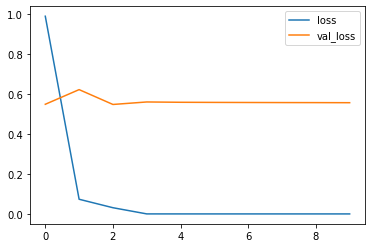

In [27]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

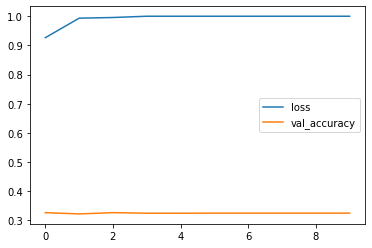

In [28]:
plt.plot(r.history['accuracy'], label='loss')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [31]:
#With normalized data

i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)

linearModel = Model(i, x)

linearModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

r = linearModel.fit(
    X_train2, Y_train,
    batch_size=128,
    epochs = 10,
    validation_data = (X_valid2, Y_valid)
)

Epoch 1/10
24/24 [==============================] - 0s 21ms/step - loss: 0.1651 - accuracy: 0.9300 - val_loss: 1.4363 - val_accuracy: 0.3233
Epoch 2/10
24/24 [==============================] - 0s 17ms/step - loss: 0.0146 - accuracy: 0.9967 - val_loss: 1.1490 - val_accuracy: 0.3233
Epoch 3/10
24/24 [==============================] - 0s 17ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 1.2008 - val_accuracy: 0.3250
Epoch 4/10
24/24 [==============================] - 0s 18ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.2642 - val_accuracy: 0.3247
Epoch 5/10
24/24 [==============================] - 0s 16ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.3071 - val_accuracy: 0.3247
Epoch 6/10
24/24 [==============================] - 0s 17ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.3175 - val_accuracy: 0.3247
Epoch 7/10
24/24 [==============================] - 0s 17ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.3641 - val_accuracy: 0.3243
Epoch 8/10
24

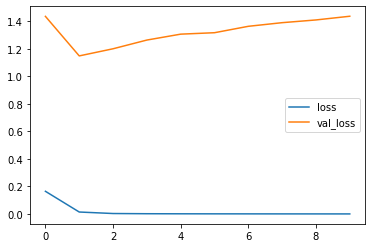

In [32]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

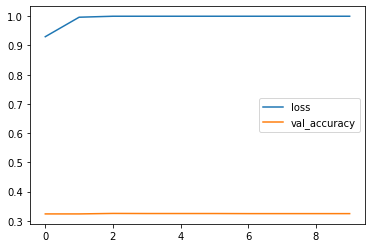

In [33]:
plt.plot(r.history['accuracy'], label='loss')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()